In [1]:
import pm4py

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from sklearn.metrics import r2_score


In [2]:
dataframe_2017 = pd.read_csv('clean_BPI_2017.csv')

/var/folders/x_/q8m53n9s7qj76786p5830ldh0000gn/T/ipykernel_89297/739368744.py:1: DtypeWarning: Columns (14,16) have mixed types. Specify dtype option on import or set low_memory=False.
  dataframe_2017 = pd.read_csv('clean_BPI_2017.csv')


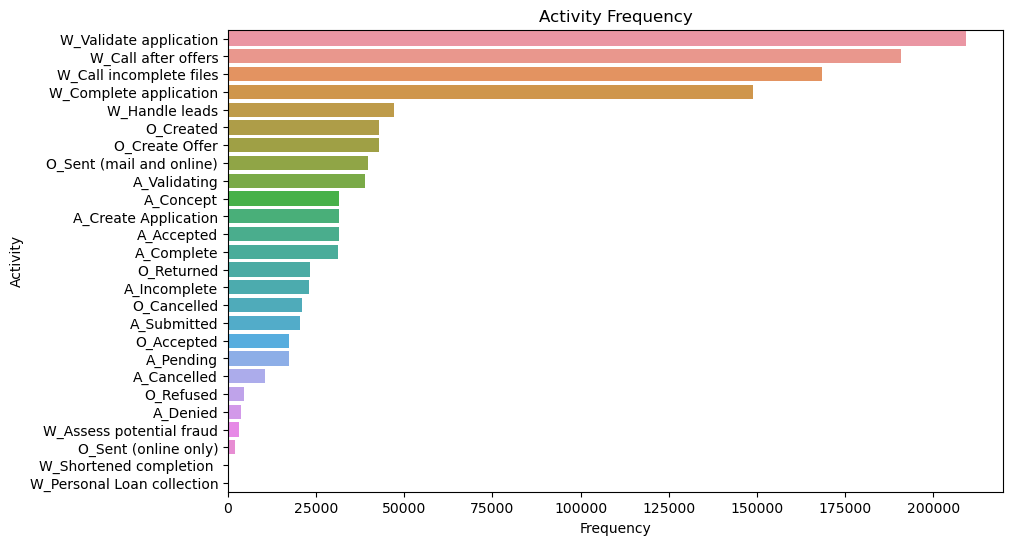

In [3]:
# Assuming 'concept:name' column contains the activity names
activity_counts = dataframe_2017['concept:name'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=activity_counts.values, y=activity_counts.index)
plt.xlabel('Frequency')
plt.ylabel('Activity')
plt.title('Activity Frequency')
plt.show()

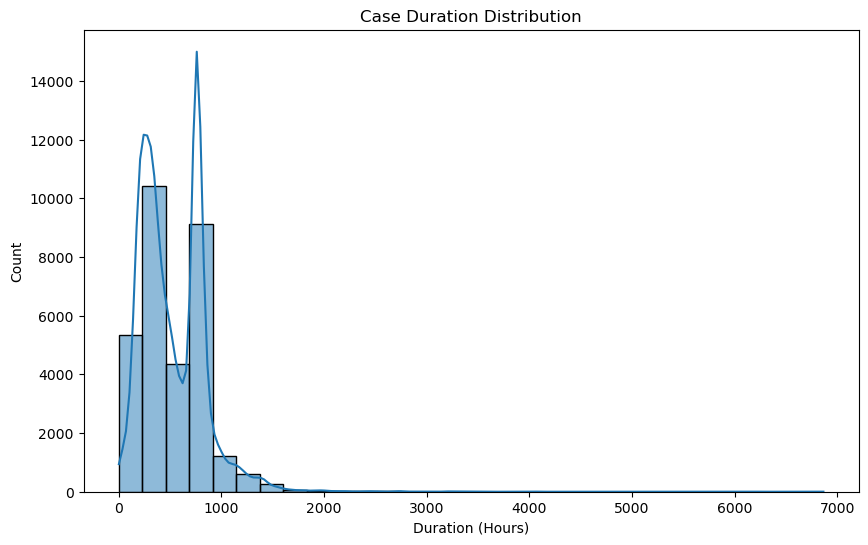

In [4]:
# Assuming 'time:timestamp' is the timestamp and 'case:concept:name' is the case ID
dataframe_2017['time:timestamp'] = pd.to_datetime(dataframe_2017['time:timestamp'])
case_durations = dataframe_2017.groupby('case:concept:name')['time:timestamp'].agg([min, max])
case_durations['duration'] = (case_durations['max'] - case_durations['min']).dt.total_seconds() / 3600  # Duration in hours

plt.figure(figsize=(10, 6))
sns.histplot(case_durations['duration'], bins=30, kde=True)
plt.xlabel('Duration (Hours)')
plt.ylabel('Count')
plt.title('Case Duration Distribution')
plt.show()


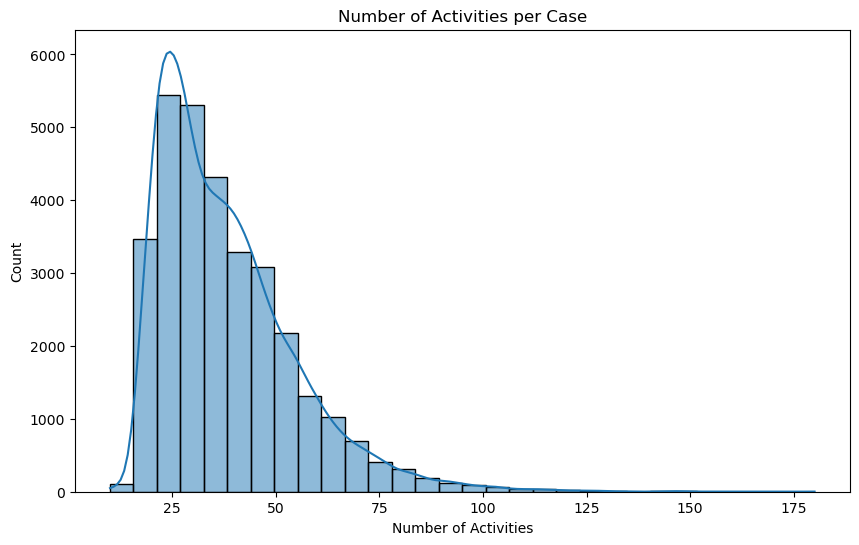

In [5]:
activities_per_case = dataframe_2017.groupby('case:concept:name').size()

plt.figure(figsize=(10, 6))
sns.histplot(activities_per_case, bins=30, kde=True)
plt.xlabel('Number of Activities')
plt.ylabel('Count')
plt.title('Number of Activities per Case')
plt.show()


In [6]:
dataframe_2017

,Unnamed: 0,Action,org:resource,concept:name,EventOrigin,EventID,lifecycle:transition,time:timestamp,case:LoanGoal,case:ApplicationType,...,case:RequestedAmount,FirstWithdrawalAmount,NumberOfTerms,Accepted,MonthlyCost,Selected,CreditScore,OfferedAmount,OfferID,timestamp_difference
0,0,Created,User_1,A_Create Application,Application,Application_652823628,complete,2016-01-01 09:51:15.304,Existing loan takeover,New credit,...,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,statechange,User_1,A_Submitted,Application,ApplState_1582051990,complete,2016-01-01 09:51:15.352,Existing loan takeover,New credit,...,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0 days 00:00:00.048000
2,2,Created,User_1,W_Handle leads,Workflow,Workitem_1298499574,schedule,2016-01-01 09:51:15.774,Existing loan takeover,New credit,...,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0 days 00:00:00.422000
3,3,Deleted,User_1,W_Handle leads,Workflow,Workitem_1673366067,withdraw,2016-01-01 09:52:36.392,Existing loan takeover,New credit,...,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0 days 00:01:20.618000
4,4,Created,User_1,W_Complete application,Workflow,Workitem_1493664571,schedule,2016-01-01 09:52:36.403,Existing loan takeover,New credit,...,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0 days 00:00:00.011000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1201085,1068830,Deleted,User_99,W_Validate application,Workflow,Workitem_1690791617,ate_abort,2017-02-01 09:58:43.972,Remaining debt home,New credit,...,29000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0 days 00:00:00.002000
1201086,1068831,statechange,User_99,O_Cancelled,Offer,OfferState_2080870299,complete,2017-02-01 09:58:43.981,Remaining debt home,New credit,...,29000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Offer_1237672415,0 days 00:00:00.009000
1201087,1068832,statechange,User_99,O_Cancelled,Offer,OfferState_1140159487,complete,2017-02-01 09:58:43.988,Remaining debt home,New credit,...,29000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Offer_1471775802,0 days 00:00:00.007000
1201088,1068833,statechange,User_99,O_Cancelled,Offer,OfferState_1987899110,complete,2017-02-01 09:58:43.994,Remaining debt home,New credit,...,29000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Offer_737795463,0 days 00:00:00.006000


In [7]:
dataframe_2017['concept:name'].value_counts()

concept:name
W_Validate application        209285
W_Call after offers           190891
W_Call incomplete files       168363
W_Complete application        148756
W_Handle leads                 47227
O_Created                      42957
O_Create Offer                 42952
O_Sent (mail and online)       39665
A_Validating                   38779
A_Concept                      31486
A_Create Application           31481
A_Accepted                     31480
A_Complete                     31337
O_Returned                     23282
A_Incomplete                   23036
O_Cancelled                    20878
A_Submitted                    20397
O_Accepted                     17210
A_Pending                      17206
A_Cancelled                    10421
O_Refused                       4689
A_Denied                        3750
W_Assess potential fraud        3278
O_Sent (online only)            2024
W_Shortened completion           238
W_Personal Loan collection        22
Name: count, dtype: int64

Text(0, 0.5, 'Frequency')

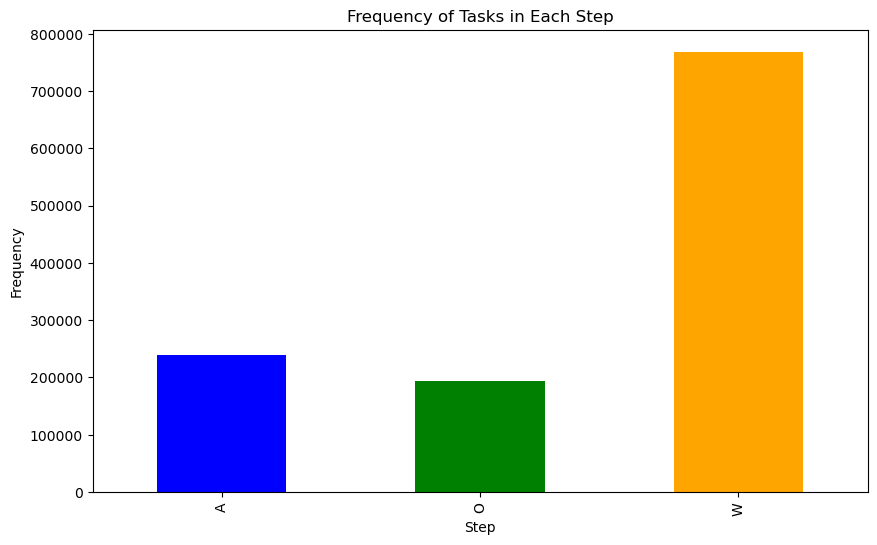

In [8]:
# Extract prefixes ('W_', 'O_', 'A_')
dataframe_2017['prefix'] = dataframe_2017['concept:name'].str.split('_').str[0]

# Create separate columns for each step
dataframe_2017['W'] = dataframe_2017['prefix'].apply(lambda x: x == 'W')
dataframe_2017['O'] = dataframe_2017['prefix'].apply(lambda x: x == 'O')
dataframe_2017['A'] = dataframe_2017['prefix'].apply(lambda x: x == 'A')

# Plot the frequency of tasks chosen at each step
fig, ax = plt.subplots(figsize=(10, 6))

dataframe_2017.groupby('prefix').size().plot(kind='bar', color=['blue', 'green', 'orange'], ax=ax)
ax.set_title('Frequency of Tasks in Each Step')
ax.set_xlabel('Step')
ax.set_ylabel('Frequency')

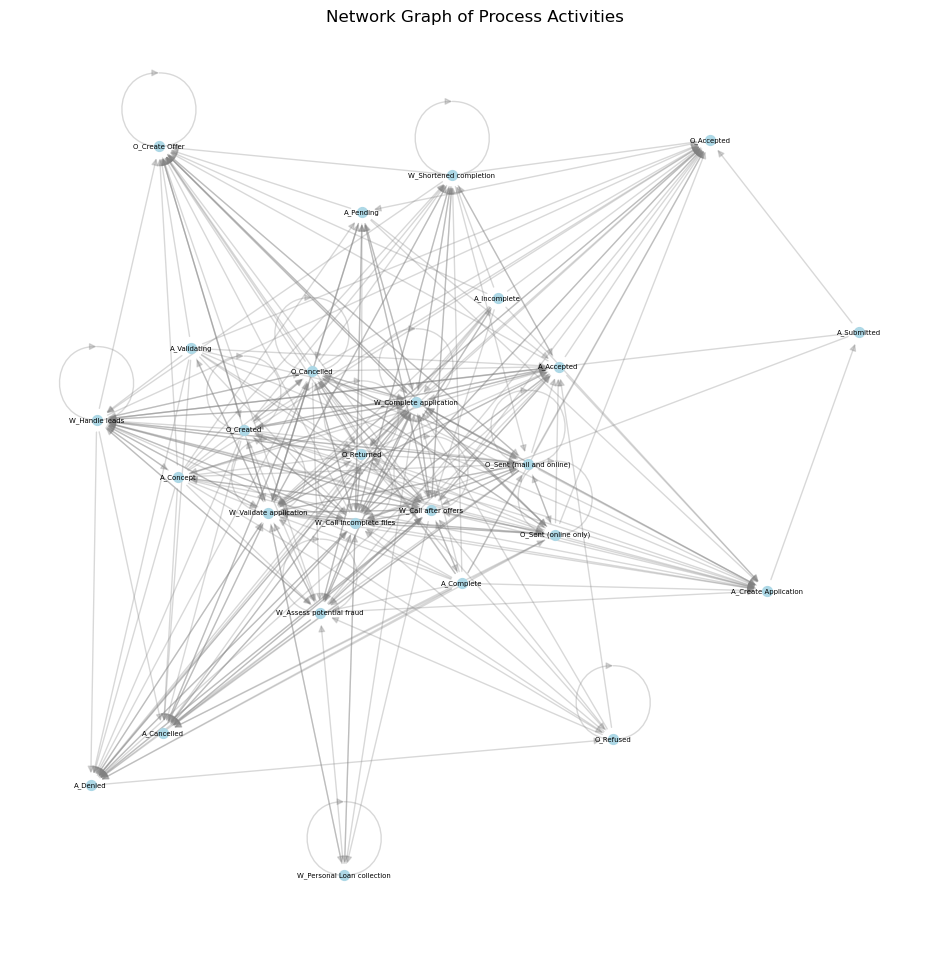

In [9]:
# Create a directed graph
G = nx.DiGraph()

# Add edges for transitions between activities for each case
# Here, we'll track the last activity to create a sequence within each case
last_activity = {}

for index, row in dataframe_2017.iterrows():
    case_id = row['case:concept:name']
    activity = row['concept:name']
    
    # Check if the current case had a previous activity
    if case_id in last_activity:
        # Add edge from last activity to current activity for the same case
        G.add_edge(last_activity[case_id], activity)
    
    # Update the last activity for the current case
    last_activity[case_id] = activity

# Use a spring layout to visualize the graph, attempting to reflect some hierarchy or sequence
pos = nx.spring_layout(G, seed=42)  # Seed for reproducible layout

# Drawing the graph
plt.figure(figsize=(12, 12))
nx.draw_networkx_nodes(G, pos, node_size=50, node_color="lightblue")
nx.draw_networkx_edges(G, pos, alpha=0.3, edge_color="gray")
nx.draw_networkx_labels(G, pos, font_size=5, font_family="sans-serif")

plt.title("Network Graph of Process Activities")
plt.axis("off")  # Turn off the axis
plt.show()

In [10]:
dataframe_2017['time:timestamp'] = pd.to_datetime(dataframe_2017['time:timestamp'])

# Generate event sequence numbers within each case
dataframe_2017['event_seq'] = dataframe_2017.groupby('case:concept:name').cumcount() + 1

dataframe_2017

,Unnamed: 0,Action,org:resource,concept:name,EventOrigin,EventID,lifecycle:transition,time:timestamp,case:LoanGoal,case:ApplicationType,...,Selected,CreditScore,OfferedAmount,OfferID,timestamp_difference,prefix,W,O,A,event_seq
0,0,Created,User_1,A_Create Application,Application,Application_652823628,complete,2016-01-01 09:51:15.304,Existing loan takeover,New credit,...,NaN,NaN,NaN,NaN,NaN,A,False,False,True,1
1,1,statechange,User_1,A_Submitted,Application,ApplState_1582051990,complete,2016-01-01 09:51:15.352,Existing loan takeover,New credit,...,NaN,NaN,NaN,NaN,0 days 00:00:00.048000,A,False,False,True,2
2,2,Created,User_1,W_Handle leads,Workflow,Workitem_1298499574,schedule,2016-01-01 09:51:15.774,Existing loan takeover,New credit,...,NaN,NaN,NaN,NaN,0 days 00:00:00.422000,W,True,False,False,3
3,3,Deleted,User_1,W_Handle leads,Workflow,Workitem_1673366067,withdraw,2016-01-01 09:52:36.392,Existing loan takeover,New credit,...,NaN,NaN,NaN,NaN,0 days 00:01:20.618000,W,True,False,False,4
4,4,Created,User_1,W_Complete application,Workflow,Workitem_1493664571,schedule,2016-01-01 09:52:36.403,Existing loan takeover,New credit,...,NaN,NaN,NaN,NaN,0 days 00:00:00.011000,W,True,False,False,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1201085,1068830,Deleted,User_99,W_Validate application,Workflow,Workitem_1690791617,ate_abort,2017-02-01 09:58:43.972,Remaining debt home,New credit,...,NaN,NaN,NaN,NaN,0 days 00:00:00.002000,W,True,False,False,73
1201086,1068831,statechange,User_99,O_Cancelled,Offer,OfferState_2080870299,complete,2017-02-01 09:58:43.981,Remaining debt home,New credit,...,NaN,NaN,NaN,Offer_1237672415,0 days 00:00:00.009000,O,False,True,False,74
1201087,1068832,statechange,User_99,O_Cancelled,Offer,OfferState_1140159487,complete,2017-02-01 09:58:43.988,Remaining debt home,New credit,...,NaN,NaN,NaN,Offer_1471775802,0 days 00:00:00.007000,O,False,True,False,75
1201088,1068833,statechange,User_99,O_Cancelled,Offer,OfferState_1987899110,complete,2017-02-01 09:58:43.994,Remaining debt home,New credit,...,NaN,NaN,NaN,Offer_737795463,0 days 00:00:00.006000,O,False,True,False,76


In [11]:
dataframe_2017 = dataframe_2017.drop(columns=['index', 'Unnamed: 0', 'level_0'])

KeyError: "['index', 'level_0'] not found in axis"

In [12]:
# Split the DataFrame into training and test sets
train_percentage = 0.8

split_index = int(len(dataframe_2017) * train_percentage)

train_set = dataframe_2017[:split_index]
test_set = dataframe_2017[split_index:]

In [13]:
dataframe_2017

,Unnamed: 0,Action,org:resource,concept:name,EventOrigin,EventID,lifecycle:transition,time:timestamp,case:LoanGoal,case:ApplicationType,...,Selected,CreditScore,OfferedAmount,OfferID,timestamp_difference,prefix,W,O,A,event_seq
0,0,Created,User_1,A_Create Application,Application,Application_652823628,complete,2016-01-01 09:51:15.304,Existing loan takeover,New credit,...,NaN,NaN,NaN,NaN,NaN,A,False,False,True,1
1,1,statechange,User_1,A_Submitted,Application,ApplState_1582051990,complete,2016-01-01 09:51:15.352,Existing loan takeover,New credit,...,NaN,NaN,NaN,NaN,0 days 00:00:00.048000,A,False,False,True,2
2,2,Created,User_1,W_Handle leads,Workflow,Workitem_1298499574,schedule,2016-01-01 09:51:15.774,Existing loan takeover,New credit,...,NaN,NaN,NaN,NaN,0 days 00:00:00.422000,W,True,False,False,3
3,3,Deleted,User_1,W_Handle leads,Workflow,Workitem_1673366067,withdraw,2016-01-01 09:52:36.392,Existing loan takeover,New credit,...,NaN,NaN,NaN,NaN,0 days 00:01:20.618000,W,True,False,False,4
4,4,Created,User_1,W_Complete application,Workflow,Workitem_1493664571,schedule,2016-01-01 09:52:36.403,Existing loan takeover,New credit,...,NaN,NaN,NaN,NaN,0 days 00:00:00.011000,W,True,False,False,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1201085,1068830,Deleted,User_99,W_Validate application,Workflow,Workitem_1690791617,ate_abort,2017-02-01 09:58:43.972,Remaining debt home,New credit,...,NaN,NaN,NaN,NaN,0 days 00:00:00.002000,W,True,False,False,73
1201086,1068831,statechange,User_99,O_Cancelled,Offer,OfferState_2080870299,complete,2017-02-01 09:58:43.981,Remaining debt home,New credit,...,NaN,NaN,NaN,Offer_1237672415,0 days 00:00:00.009000,O,False,True,False,74
1201087,1068832,statechange,User_99,O_Cancelled,Offer,OfferState_1140159487,complete,2017-02-01 09:58:43.988,Remaining debt home,New credit,...,NaN,NaN,NaN,Offer_1471775802,0 days 00:00:00.007000,O,False,True,False,75
1201088,1068833,statechange,User_99,O_Cancelled,Offer,OfferState_1987899110,complete,2017-02-01 09:58:43.994,Remaining debt home,New credit,...,NaN,NaN,NaN,Offer_737795463,0 days 00:00:00.006000,O,False,True,False,76


In [14]:
# Calculate the difference between the current event's timestamp and the next one
dataframe_2017['time_to_next_event'] = dataframe_2017.groupby('case:concept:name')['time:timestamp'].transform(lambda x: x.diff().shift(-1))

# Convert the 'time_to_next_event' from timedelta to seconds (or any other numeric representation you prefer)
dataframe_2017['time_to_next_event_seconds'] = dataframe_2017['time_to_next_event'].dt.total_seconds().fillna(0)

# Step 2: Compute the mean duration for each 'concept:name'
average_durations_per_concept = dataframe_2017[['time_to_next_event_seconds', 'concept:name']].groupby('concept:name').median().rename(columns={'time_to_next_event_seconds': 'mean_duration_seconds'})

# Step 3: Merge this mean duration back into the original dataframe to use as a prediction
dataframe_2017 = pd.merge(dataframe_2017, average_durations_per_concept, how='left', on='concept:name')

# Rename the 'mean_duration_seconds' column to something like 'predicted_duration_seconds'
dataframe_2017.rename(columns={'mean_duration_seconds': 'predicted_time_to_next_event_seconds'}, inplace=True)

dataframe_2017[['predicted_time_to_next_event_seconds', 'time_to_next_event_seconds']] = dataframe_2017[['predicted_time_to_next_event_seconds', 'time_to_next_event_seconds']].round(2)

# Optionally, convert the 'predicted_time_to_next_event_seconds' back to a timedelta for readability or further datetime operations
# dataframe_2012['predicted_time_to_next_event'] = pd.to_timedelta(dataframe_2012['predicted_time_to_next_event_seconds'], unit='s')

dataframe_2017

,Unnamed: 0,Action,org:resource,concept:name,EventOrigin,EventID,lifecycle:transition,time:timestamp,case:LoanGoal,case:ApplicationType,...,OfferID,timestamp_difference,prefix,W,O,A,event_seq,time_to_next_event,time_to_next_event_seconds,predicted_time_to_next_event_seconds
0,0,Created,User_1,A_Create Application,Application,Application_652823628,complete,2016-01-01 09:51:15.304,Existing loan takeover,New credit,...,NaN,NaN,A,False,False,True,1,0 days 00:00:00.048000,0.05,0.04
1,1,statechange,User_1,A_Submitted,Application,ApplState_1582051990,complete,2016-01-01 09:51:15.352,Existing loan takeover,New credit,...,NaN,0 days 00:00:00.048000,A,False,False,True,2,0 days 00:00:00.422000,0.42,0.30
2,2,Created,User_1,W_Handle leads,Workflow,Workitem_1298499574,schedule,2016-01-01 09:51:15.774,Existing loan takeover,New credit,...,NaN,0 days 00:00:00.422000,W,True,False,False,3,0 days 00:01:20.618000,80.62,35.17
3,3,Deleted,User_1,W_Handle leads,Workflow,Workitem_1673366067,withdraw,2016-01-01 09:52:36.392,Existing loan takeover,New credit,...,NaN,0 days 00:01:20.618000,W,True,False,False,4,0 days 00:00:00.011000,0.01,35.17
4,4,Created,User_1,W_Complete application,Workflow,Workitem_1493664571,schedule,2016-01-01 09:52:36.403,Existing loan takeover,New credit,...,NaN,0 days 00:00:00.011000,W,True,False,False,5,0 days 00:00:00.010000,0.01,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1201085,1068830,Deleted,User_99,W_Validate application,Workflow,Workitem_1690791617,ate_abort,2017-02-01 09:58:43.972,Remaining debt home,New credit,...,NaN,0 days 00:00:00.002000,W,True,False,False,73,0 days 00:00:00.009000,0.01,0.02
1201086,1068831,statechange,User_99,O_Cancelled,Offer,OfferState_2080870299,complete,2017-02-01 09:58:43.981,Remaining debt home,New credit,...,Offer_1237672415,0 days 00:00:00.009000,O,False,True,False,74,0 days 00:00:00.007000,0.01,0.01
1201087,1068832,statechange,User_99,O_Cancelled,Offer,OfferState_1140159487,complete,2017-02-01 09:58:43.988,Remaining debt home,New credit,...,Offer_1471775802,0 days 00:00:00.007000,O,False,True,False,75,0 days 00:00:00.006000,0.01,0.01
1201088,1068833,statechange,User_99,O_Cancelled,Offer,OfferState_1987899110,complete,2017-02-01 09:58:43.994,Remaining debt home,New credit,...,Offer_737795463,0 days 00:00:00.006000,O,False,True,False,76,0 days 00:00:00.007000,0.01,0.01


In [15]:
dataframe_2017['column_similarity_percentage'] = (dataframe_2017['time_to_next_event_seconds'] == dataframe_2017['predicted_time_to_next_event_seconds']).mean() * 100

accuracy = dataframe_2017['column_similarity_percentage'].loc[0]

In [16]:
accuracy

15.83320150862966

In [17]:
r2 = r2_score(dataframe_2017['time_to_next_event_seconds'], dataframe_2017['predicted_time_to_next_event_seconds'])

r2

0.02292218953693359

In [18]:

dataframe_2017 = dataframe_2017.drop(columns=['column_similarity_percentage'])


In [19]:
# Subtract the timestamp of the first event in each case from all events in that case
dataframe_2017['elapsed_time_from_start'] = dataframe_2017.groupby('case:concept:name')['time:timestamp'].transform(lambda x: x - x.min())

# Calculate the average elapsed time from the start for each 'event_seq'
predicted_start_time = dataframe_2017.groupby('event_seq')['elapsed_time_from_start'].mean().reset_index(name='predicted_start_time')

# Merge this average elapsed time back into the original DataFrame to use as a predicted start time
dataframe_2017 = pd.merge(dataframe_2017, predicted_start_time, on='event_seq', how='left')

In [20]:
dataframe_2017

,Unnamed: 0,Action,org:resource,concept:name,EventOrigin,EventID,lifecycle:transition,time:timestamp,case:LoanGoal,case:ApplicationType,...,prefix,W,O,A,event_seq,time_to_next_event,time_to_next_event_seconds,predicted_time_to_next_event_seconds,elapsed_time_from_start,predicted_start_time
0,0,Created,User_1,A_Create Application,Application,Application_652823628,complete,2016-01-01 09:51:15.304,Existing loan takeover,New credit,...,A,False,False,True,1,0 days 00:00:00.048000,0.05,0.04,0 days 00:00:00,4 days 18:38:55.010316100
1,1,statechange,User_1,A_Submitted,Application,ApplState_1582051990,complete,2016-01-01 09:51:15.352,Existing loan takeover,New credit,...,A,False,False,True,2,0 days 00:00:00.422000,0.42,0.30,0 days 00:00:00.048000,4 days 18:50:11.306445745
2,2,Created,User_1,W_Handle leads,Workflow,Workitem_1298499574,schedule,2016-01-01 09:51:15.774,Existing loan takeover,New credit,...,W,True,False,False,3,0 days 00:01:20.618000,80.62,35.17,0 days 00:00:00.470000,5 days 03:53:50.679851693
3,3,Deleted,User_1,W_Handle leads,Workflow,Workitem_1673366067,withdraw,2016-01-01 09:52:36.392,Existing loan takeover,New credit,...,W,True,False,False,4,0 days 00:00:00.011000,0.01,35.17,0 days 00:01:21.088000,5 days 16:10:11.014999397
4,4,Created,User_1,W_Complete application,Workflow,Workitem_1493664571,schedule,2016-01-01 09:52:36.403,Existing loan takeover,New credit,...,W,True,False,False,5,0 days 00:00:00.010000,0.01,0.01,0 days 00:01:21.099000,5 days 08:22:12.629814592
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1201085,1068830,Deleted,User_99,W_Validate application,Workflow,Workitem_1690791617,ate_abort,2017-02-01 09:58:43.972,Remaining debt home,New credit,...,W,True,False,False,73,0 days 00:00:00.009000,0.01,0.02,75 days 14:18:05.738000,20 days 05:59:20.038348289
1201086,1068831,statechange,User_99,O_Cancelled,Offer,OfferState_2080870299,complete,2017-02-01 09:58:43.981,Remaining debt home,New credit,...,O,False,True,False,74,0 days 00:00:00.007000,0.01,0.01,75 days 14:18:05.747000,20 days 07:06:36.925158626
1201087,1068832,statechange,User_99,O_Cancelled,Offer,OfferState_1140159487,complete,2017-02-01 09:58:43.988,Remaining debt home,New credit,...,O,False,True,False,75,0 days 00:00:00.006000,0.01,0.01,75 days 14:18:05.754000,20 days 04:04:09.814735216
1201088,1068833,statechange,User_99,O_Cancelled,Offer,OfferState_1987899110,complete,2017-02-01 09:58:43.994,Remaining debt home,New credit,...,O,False,True,False,76,0 days 00:00:00.007000,0.01,0.01,75 days 14:18:05.760000,20 days 20:27:52.468876894


In [21]:
# Step 1: Shift the 'concept:name' within each group to get the next step
# dataframe_2012['next_step'] = dataframe_2012.groupby('case:concept:name')['concept:name'].shift(-1)

# Step 2: For each 'concept:name', calculate the most common next step
# We'll group by 'concept:name' and then use value_counts on 'next_step' to find the most common follow-up step
#most_common_next_steps = dataframe_2012.groupby('concept:name')['next_step'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None).reset_index(n

# Merge the most common next step back into the original DataFrame
#dataframe_2012 = pd.merge(dataframe_2012, most_common_next_steps, how='left', on='concept:name')

# Rename the merged column to 'predicted_next_step'
#dataframe_2012.rename(columns={'most_common_next_step': 'predicted_next_step'}, inplace=True)

In [22]:
# Calculate the most common concept:name for each event_seq
most_common_concepts_by_seq = dataframe_2017.groupby('event_seq')['concept:name'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None).reset_index(name='predicted_step')
# Merge the most common concept:name for each event_seq back into the original DataFrame
dataframe_2017 = pd.merge(dataframe_2017, most_common_concepts_by_seq, on='event_seq', how='left')

In [23]:
dataframe_2017.to_csv("BPI_2017_naive.csv")

In [24]:
dataframe_2017['column_similarity_percentage'] = (dataframe_2017['concept:name'] == dataframe_2017['predicted_step']).mean() * 100

accuracy = dataframe_2017['column_similarity_percentage'].loc[0]

In [25]:
accuracy

29.05286031854399